In [2]:
import os
import re
import io
import requests
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
from zipfile import ZipFile

In [3]:
#Next we start a graph session and set the RNN model parameters. We will run the data through 20 epochs, in batch sizes
#of 250. The maximum length if each text we will consider is 25 words; we will cut longer texts to 25 or zero pad shorter
#texts.The RNN will be of size 10 units. We will only consider words that appear at least 10 times in our vocabulary, and
#every word will be embedded in a trainable vector of size 50. The dropout rate will be a placeholder that we can set at
#0.5 during training time or 1.0 during evaluation
sess = tf.Session()
epochs = 20
batch_size = 250
max_sequence_length = 25
rnn_size = 10
embedding_size = 50
min_word_frequency = 10
learning_rate = 0.0005
dropout_keep_prob = tf.placeholder(tf.float32)

In [4]:
#Now we get the SMS text data. First, we check if it wasa already downloaded and, if so, read in the file. Otherwise,
#download and save it
data_dir = 'temp'
data_file = 'text_data.txt'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

if not os.path.isfile(os.path.join(data_dir, data_file)):
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    # Format Data
    text_data = file.decode()
    text_data = text_data.encode('ascii',errors='ignore')
    text_data = text_data.decode().split('\n')

    # Save data to text file
    with open(os.path.join(data_dir, data_file), 'w') as file_conn:
        for text in text_data:
            file_conn.write("{}\n".format(text))
else:
    # Open data from text file
    text_data = []
    with open(os.path.join(data_dir, data_file), 'r') as file_conn:
        for row in file_conn:
            text_data.append(row)
    text_data = text_data[:-1]

text_data = [x.split('\t') for x in text_data if len(x)>=1]
[text_data_target, text_data_train] = [list(x) for x in zip(*text_data)]

In [5]:
#To reduce our vocabulary, we will clean the input texts by removing special characters, extra white space, and putting 
#everything in lowercase: 
def clean_text(text_string):
    text_string = re.sub(r'([^\s\w]|_|[0-9])+', '', text_string)
    text_string = " ".join(text_string.split())
    text_string = text_string.lower()
    return(text_string)

In [6]:
#Now we pricess the texts with a built in vocabulary processor function from TensorFlow. This will convert a text to an 
#appropriate list of indices:
vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(max_sequence_length, min_frequency=min_word_frequency)
text_processed = np.array(list(vocab_processor.fit_transform(text_data_train)))

In [7]:
#Next we shuffle the data to randomize the data
text_processed = np.array(text_processed)
text_data_target = np.array([1 if x=='ham' else 0 for x in text_data_target])
shuffled_ix = np.random.permutation(np.arange(len(text_data_target)))
x_shuffled = text_processed[shuffled_ix]
y_shuffled = text_data_target[shuffled_ix]

In [8]:
#We also split the data into an 80-20 train-test dataset
ix_cutoff = int(len(y_shuffled)*0.80)
x_train, x_test = x_shuffled[:ix_cutoff], x_shuffled[ix_cutoff:]
y_train, y_test = y_shuffled[:ix_cutoff], y_shuffled[ix_cutoff:]
vocab_size = len(vocab_processor.vocabulary_)
print("Vocabulary Size: {:d}".format(vocab_size))
print("80-20 Train Test split: {:d} -- {:d}".format(len(y_train), len(y_test)))

Vocabulary Size: 1124
80-20 Train Test split: 4459 -- 1115


In [9]:
#Next we declare the graph placeholders. The x-input will be a placeholder of size [none, max_sequence_length], which
#will be the batch size by the maximum allowed word length of the text messages. The y-output placeholder is just an 
#integer, 0 or 1, or ham or spam
x_data = tf.placeholder(tf.int32, [None,max_sequence_length])
y_output = tf.placeholder(tf.int32, [None])

In [10]:
#We now create our embedding matrix and embedding lookup operation for the x-input data:
embedding_mat = tf.Variable(tf.random_uniform([vocab_size,embedding_size], -1.0, 1.0))
embedding_output = tf.nn.embedding_lookup(embedding_mat, x_data)

In [11]:
#We declare our model as follows. First we initialize a type of RNN cell to use (RNN of size 10). Then we create the RNN
#sequence by making it a dynamic RNN. We then add a droupout to the RNN. 
cell = tf.nn.rnn_cell.BasicRNNCell(num_units=rnn_size)
output, state = tf.nn.dynamic_rnn(cell, embedding_output, dtype=tf.float32)
output = tf.nn.dropout(output, dropout_keep_prob)

In [12]:
#Now to get our predictions, we have to rearrange the RNN and slice off the last output
output = tf.transpose(output, [1,0,2])
last = tf.gather(output, int(output.get_shape()[0])-1)

In [13]:
#To finish the RNN prediction, we convert from the rnn_size output to the two-category output via a fully connected
#network layer
weight = tf.Variable(tf.truncated_normal([rnn_size, 2], stddev=0.1))
bias = tf.Variable(tf.constant(0,1, shape=[2]))
logits_out = tf.nn.softmax(tf.matmul(last, weight) + bias)

In [14]:
#We declare our loss function next.Remember that  with using the sparse_softmax functino from TensorFlow, the targets 
#have to be integer indices (of type int), and the logits have to be floats
losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_out, labels=y_output)
loss = tf.reduce_mean(losses)

In [15]:
#We also need an accuracy functino so that we can compare the algorithm on the test and train set
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits_out, 1), tf.cast(y_output, tf.int64)), tf.float32))

In [16]:
#Next we create the optimization function and initialize the model variables. 
optimizer = tf.train.RMSPropOptimizer(learning_rate)
train_step = optimizer.minimize(loss)
init = tf.initialize_all_variables()
sess.run(init)

/home/huzeyfekiran/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [18]:
#Now we start looping through our data and training the model. When looping through the data multiple times, it is good 
#practice to shuffle the data every epoch to prevent over-training
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
# Start training
for epoch in range(epochs):

    # Shuffle training data
    shuffled_ix = np.random.permutation(np.arange(len(x_train)))
    x_train = x_train[shuffled_ix]
    y_train = y_train[shuffled_ix]
    num_batches = int(len(x_train)/batch_size) + 1
    # TO DO CALCULATE GENERATIONS ExACTLY
    for i in range(num_batches):
        # Select train data
        min_ix = i * batch_size
        max_ix = np.min([len(x_train), ((i+1) * batch_size)])
        x_train_batch = x_train[min_ix:max_ix]
        y_train_batch = y_train[min_ix:max_ix]
        
        # Run train step
        train_dict = {x_data: x_train_batch, y_output: y_train_batch, dropout_keep_prob:0.5}
        sess.run(train_step, feed_dict=train_dict)
        
    # Run loss and accuracy for training
    temp_train_loss, temp_train_acc = sess.run([loss, accuracy], feed_dict=train_dict)
    train_loss.append(temp_train_loss)
    train_accuracy.append(temp_train_acc)
    
    # Run Eval Step
    test_dict = {x_data: x_test, y_output: y_test, dropout_keep_prob:1.0}
    temp_test_loss, temp_test_acc = sess.run([loss, accuracy], feed_dict=test_dict)
    test_loss.append(temp_test_loss)
    test_accuracy.append(temp_test_acc)
    print('Epoch: {}, Test Loss: {:.2}, Test Acc: {:.2}'.format(epoch+1, temp_test_loss, temp_test_acc))

Epoch: 1, Test Loss: 0.64, Test Acc: 0.86
Epoch: 2, Test Loss: 0.62, Test Acc: 0.85
Epoch: 3, Test Loss: 0.6, Test Acc: 0.86
Epoch: 4, Test Loss: 0.57, Test Acc: 0.86
Epoch: 5, Test Loss: 0.55, Test Acc: 0.86
Epoch: 6, Test Loss: 0.53, Test Acc: 0.86
Epoch: 7, Test Loss: 0.51, Test Acc: 0.86
Epoch: 8, Test Loss: 0.5, Test Acc: 0.86
Epoch: 9, Test Loss: 0.49, Test Acc: 0.86
Epoch: 10, Test Loss: 0.48, Test Acc: 0.86
Epoch: 11, Test Loss: 0.47, Test Acc: 0.86
Epoch: 12, Test Loss: 0.47, Test Acc: 0.86
Epoch: 13, Test Loss: 0.46, Test Acc: 0.86
Epoch: 14, Test Loss: 0.46, Test Acc: 0.86
Epoch: 15, Test Loss: 0.46, Test Acc: 0.86
Epoch: 16, Test Loss: 0.46, Test Acc: 0.86
Epoch: 17, Test Loss: 0.45, Test Acc: 0.86
Epoch: 18, Test Loss: 0.45, Test Acc: 0.86
Epoch: 19, Test Loss: 0.45, Test Acc: 0.86
Epoch: 20, Test Loss: 0.45, Test Acc: 0.86


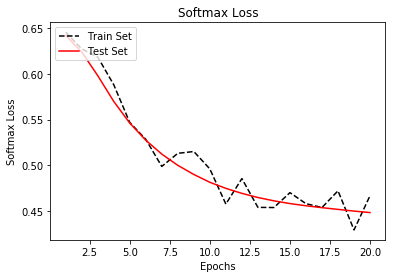

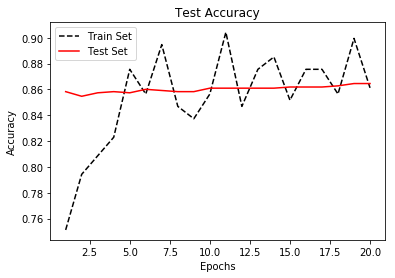

In [19]:
#plot train/test loss and accuracy

# Plot loss over time
epoch_seq = np.arange(1, epochs+1)
plt.plot(epoch_seq, train_loss, 'k--', label='Train Set')
plt.plot(epoch_seq, test_loss, 'r-', label='Test Set')
plt.title('Softmax Loss')
plt.xlabel('Epochs')
plt.ylabel('Softmax Loss')
plt.legend(loc='upper left')
plt.show()

# Plot accuracy over time
plt.plot(epoch_seq, train_accuracy, 'k--', label='Train Set')
plt.plot(epoch_seq, test_accuracy, 'r-', label='Test Set')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()